In [83]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


In [5]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [6]:
df=sns.load_dataset('flights')
df.head(2)

,year,month,passengers
0,1949,January,112
1,1949,February,118


In [20]:
pd.isna(df).sum()

year          0
month         0
passengers    0
dtype: int64

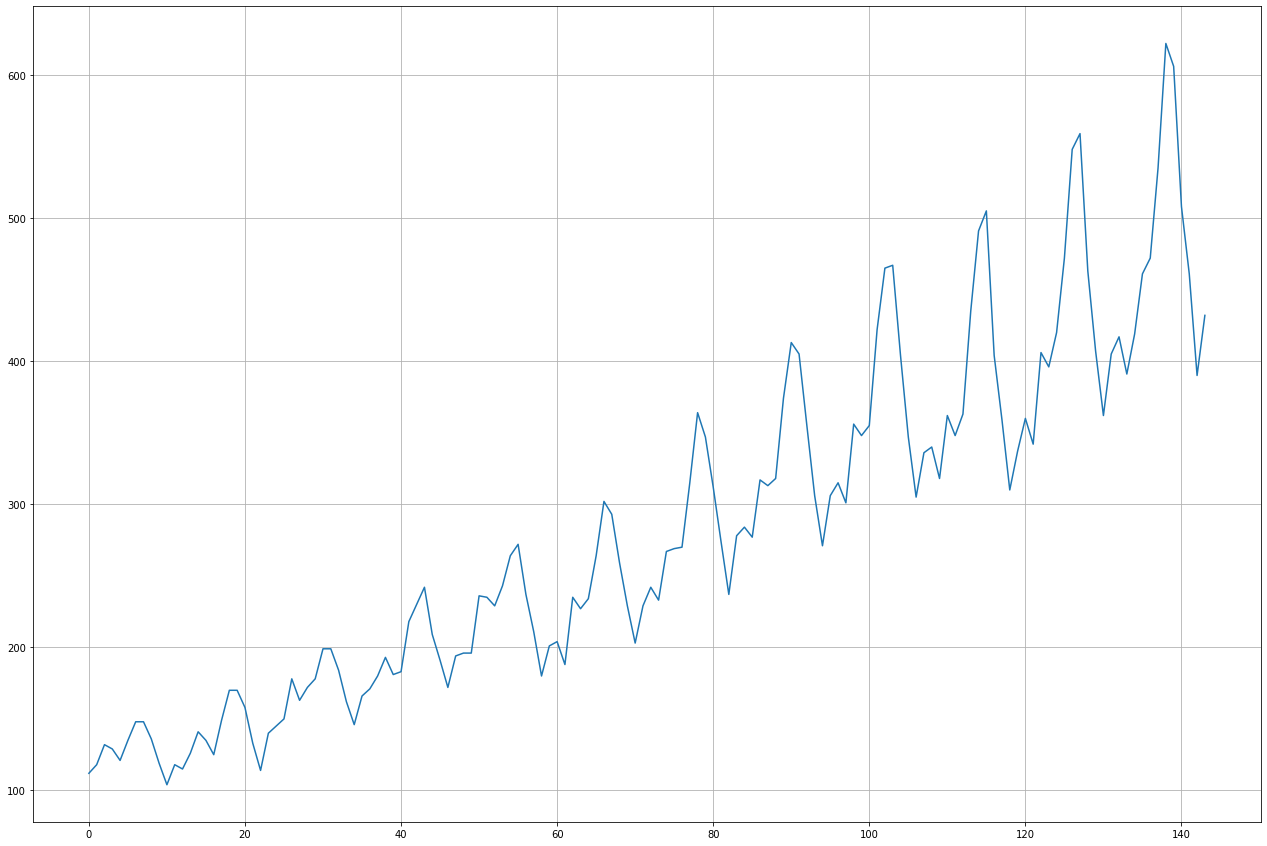

In [30]:
plt.figure(figsize=(22,15))
plt.plot(df['passengers'])
plt.grid()

In [33]:
df.dtypes

year             int64
month         category
passengers       int64
dtype: object

In [34]:
## Data set division b/w train and test set

In [35]:
df.shape

(144, 3)

In [69]:
test_size=14

train_data=df.passengers[:-test_size]
test_data=df.passengers[-test_size:]

test_data.head()

130    362
131    405
132    417
133    391
134    419
Name: passengers, dtype: int64

In [70]:
from sklearn.preprocessing import MinMaxScaler
train_data=train_data.to_numpy(dtype=float)
test_data=test_data.to_numpy(dtype=float)

scaler=MinMaxScaler(feature_range=(-1,1))


normalized_train_data=scaler.fit_transform(train_data.reshape(-1,1))

In [72]:
normalized_train_data[:2]

array([[-0.96483516],
       [-0.93846154]])

In [73]:
normalized_train_data=torch.FloatTensor(normalized_train_data).view(-1)

In [74]:
normalized_train_data[:2]

tensor([-0.9648, -0.9385])

In [75]:
def create_input_sequence(input_data,train_window):
    seq=[]
    L=len(input_data)
    for i in range(L-train_window):
        train_Seq = input_data[i:i+train_window]
        train_label=input_data[i+train_window:i+train_window+1]
        seq.append((train_Seq,train_label))
    return seq
        

In [76]:
# train_window is kept at 12 as no. of months
train_input_seq= create_input_sequence(normalized_train_data,12)

In [79]:
train_input_seq[:2]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033]))]

In [91]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_layer_size=100,output_size=1):
        super().__init__()
        self.hidden_layer_size=hidden_layer_size
        
        self.lstm=nn.LSTM(input_size,hidden_layer_size)
        
        self.linear=nn.Linear(hidden_layer_size, output_size)
        
        self.hidden_cell= (torch.zeros(1,1,self.hidden_layer_size),
                           torch.zeros(1,1,self.hidden_layer_size))
        
        
    def forward(self,input_seq):
        lstm_out,self.hidden_cell= self.lstm(input_seq.view(len(input_seq),1,-1),self.hidden_cell)
        predictions=self.linear(lstm_out.view(len(input_seq),-1))
        
        return predictions[-1]
        

In [92]:
model= LSTM()
lr=0.01
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [93]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [105]:
epochs=150

for epoch in range(epochs):
    for seq,label in train_input_seq:
        optimizer.zero_grad()
        model.hidden_cell= (torch.zeros(1,1,model.hidden_layer_size),
                           torch.zeros(1,1,model.hidden_layer_size))
        y_pred=model(seq)
        
        single_loss=loss_function(y_pred,label)
        single_loss.backward()
        optimizer.step()
        
    if(epoch %25==0):
        print(f"Loss for {epoch}: {single_loss.item()}")

Loss for 0: 0.2262887805700302
Loss for 25: 0.0020714823622256517
Loss for 50: 0.0035688220523297787
Loss for 75: 0.003436245722696185
Loss for 100: 0.0007157170912250876
Loss for 125: 0.0013750935904681683


In [110]:
test_inputs=normalized_train_data[-12:].tolist() #12 is Training window
model.eval()

for i in range(14):
    seq= torch.FloatTensor(test_inputs[-12:]) # 12 is training window
    with torch.no_grad():
        model.hidden=(torch.zeros(1,1,model.hidden_layer_size),
                           torch.zeros(1,1,model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [113]:
test_inputs[12:]

[0.1610565185546875,
 0.2958197593688965,
 0.6028953790664673,
 1.0346158742904663,
 1.2923163175582886,
 1.0753884315490723,
 0.8272864818572998,
 0.6492809653282166,
 0.5436476469039917,
 0.4543725848197937,
 0.38673725724220276,
 0.40073513984680176,
 0.6323467493057251,
 1.0708016157150269]

In [117]:
actual_pred= scaler.inverse_transform(np.array(test_inputs[12:]).reshape(-1,1))

In [118]:
actual_pred

array([[368.14035797],
       [398.79899526],
       [468.65869874],
       [566.8751114 ],
       [625.50196224],
       [576.15086818],
       [519.70767462],
       [479.21141961],
       [455.17983967],
       [434.86976305],
       [419.48272602],
       [422.66724432],
       [475.35888547],
       [575.10736758]])

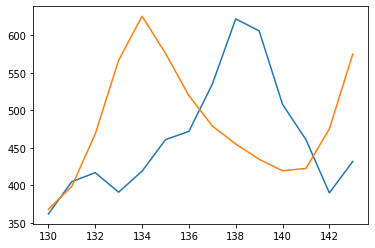

In [124]:
x=np.arange(130,144,1)
plt.plot(df['passengers'][-14:])
plt.plot(x,actual_pred)